<a href="https://colab.research.google.com/github/cfonderson/portfolio/blob/main/Data%20Science/Financial%20Fraud%20Detection/finfraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying and predicting fraudulent financial transactions using machine learning

Fraud costs businesses in profits and brand reputation. In some instances, the losses are irreparable or take years to recoup. Therefore, learning how to detect fraud detection in accounts payable is crucial to continue timely production.

In this project, I used classification algorithms to identify and predict fraudulent financial transactions at a credit card fraud. 

The dataset used was sourced from Kaggle user `mlg-ulb`, and it contains 284,807 transactions collected over a period of two days. Customer information has been anonymized and standardized. The amount exchanged in each transaction was also indicated, as well as an indicator of fraudulent activity. 

## Modeling
Since the dataset was heavily imbalanced, I chose to consider two methods to build highly accurate predictive models, namely data resampling and the Synthetic Minority Over-sampling Technique (SMOTE). Furthermore, four (4) classification algorithms were tested in this project (Logistic Regression, KNearest Neighbors, Support Vector and Decision Tree Classifiers).

Following resampling and SMOTE, all classifiers performed with high accuracy (>90%), but the Decision Tree Classifier outperformed the others, with an accuracy of 100%.

## Results
Although resampling improved the performance of the classification models, with an accuracy over 94%, SMOTE did not improve models' performances. Indeed, the precision and f1-scores for modeling on the balanced dataset were 60% lower than that of the imbalanced dataset.

![fraud](img/fraud.png)


In [1]:
# data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# machine learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced


# other libraries
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# kaggle api credentials
creds = pd.read_csv('api_keys.csv')
kaggle_creds = creds[creds['NAME']=='kaggle']

os.environ['KAGGLE_USERNAME'] = kaggle_creds['USER'].values[0]
os.environ['KAGGLE_KEY'] = kaggle_creds['KEY'].values[0]

# downloading the dataset
! kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


## Exploratory data analysis

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# statistical summary 
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# checking for null values
df.isnull().all().sum()

0

In [7]:
# checking for duplicate records
df.duplicated().all().sum()

0

In [8]:
# exploring the `Class` column
#df.Class.value_counts()

print('Not Fraudulent Cases:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '%')
print('Fraudulent Cases:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '%')

Not Fraudulent Cases: 99.83 %
Fraudulent Cases: 0.17 %


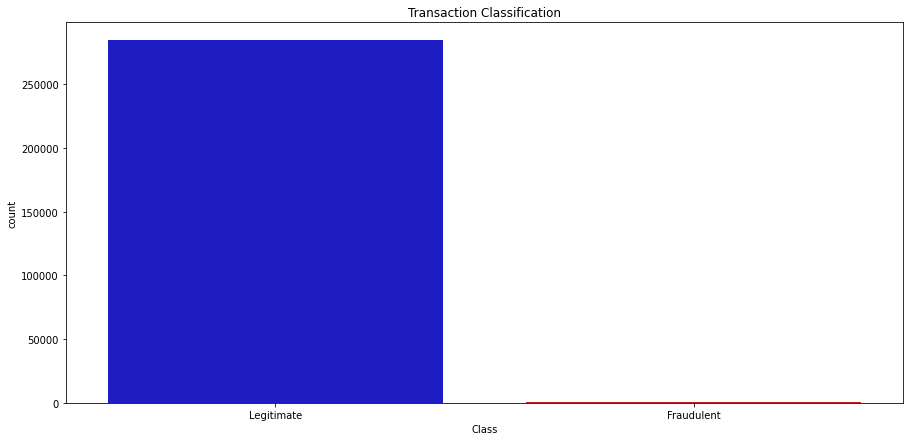

In [9]:
# defining the x-axis
x, labels = [0, 1], ['Legitimate', 'Fraudulent']
colors = ["#0101DF", "#DF0101"]

plt.figure(figsize=(15,7))
sns.countplot(data=df, x='Class', palette=colors)
plt.xticks(x, labels)
plt.title('Transaction Classification')
plt.show()

**Note:** This is an imbalanced dataset, so we will have to deal with this during our analyses

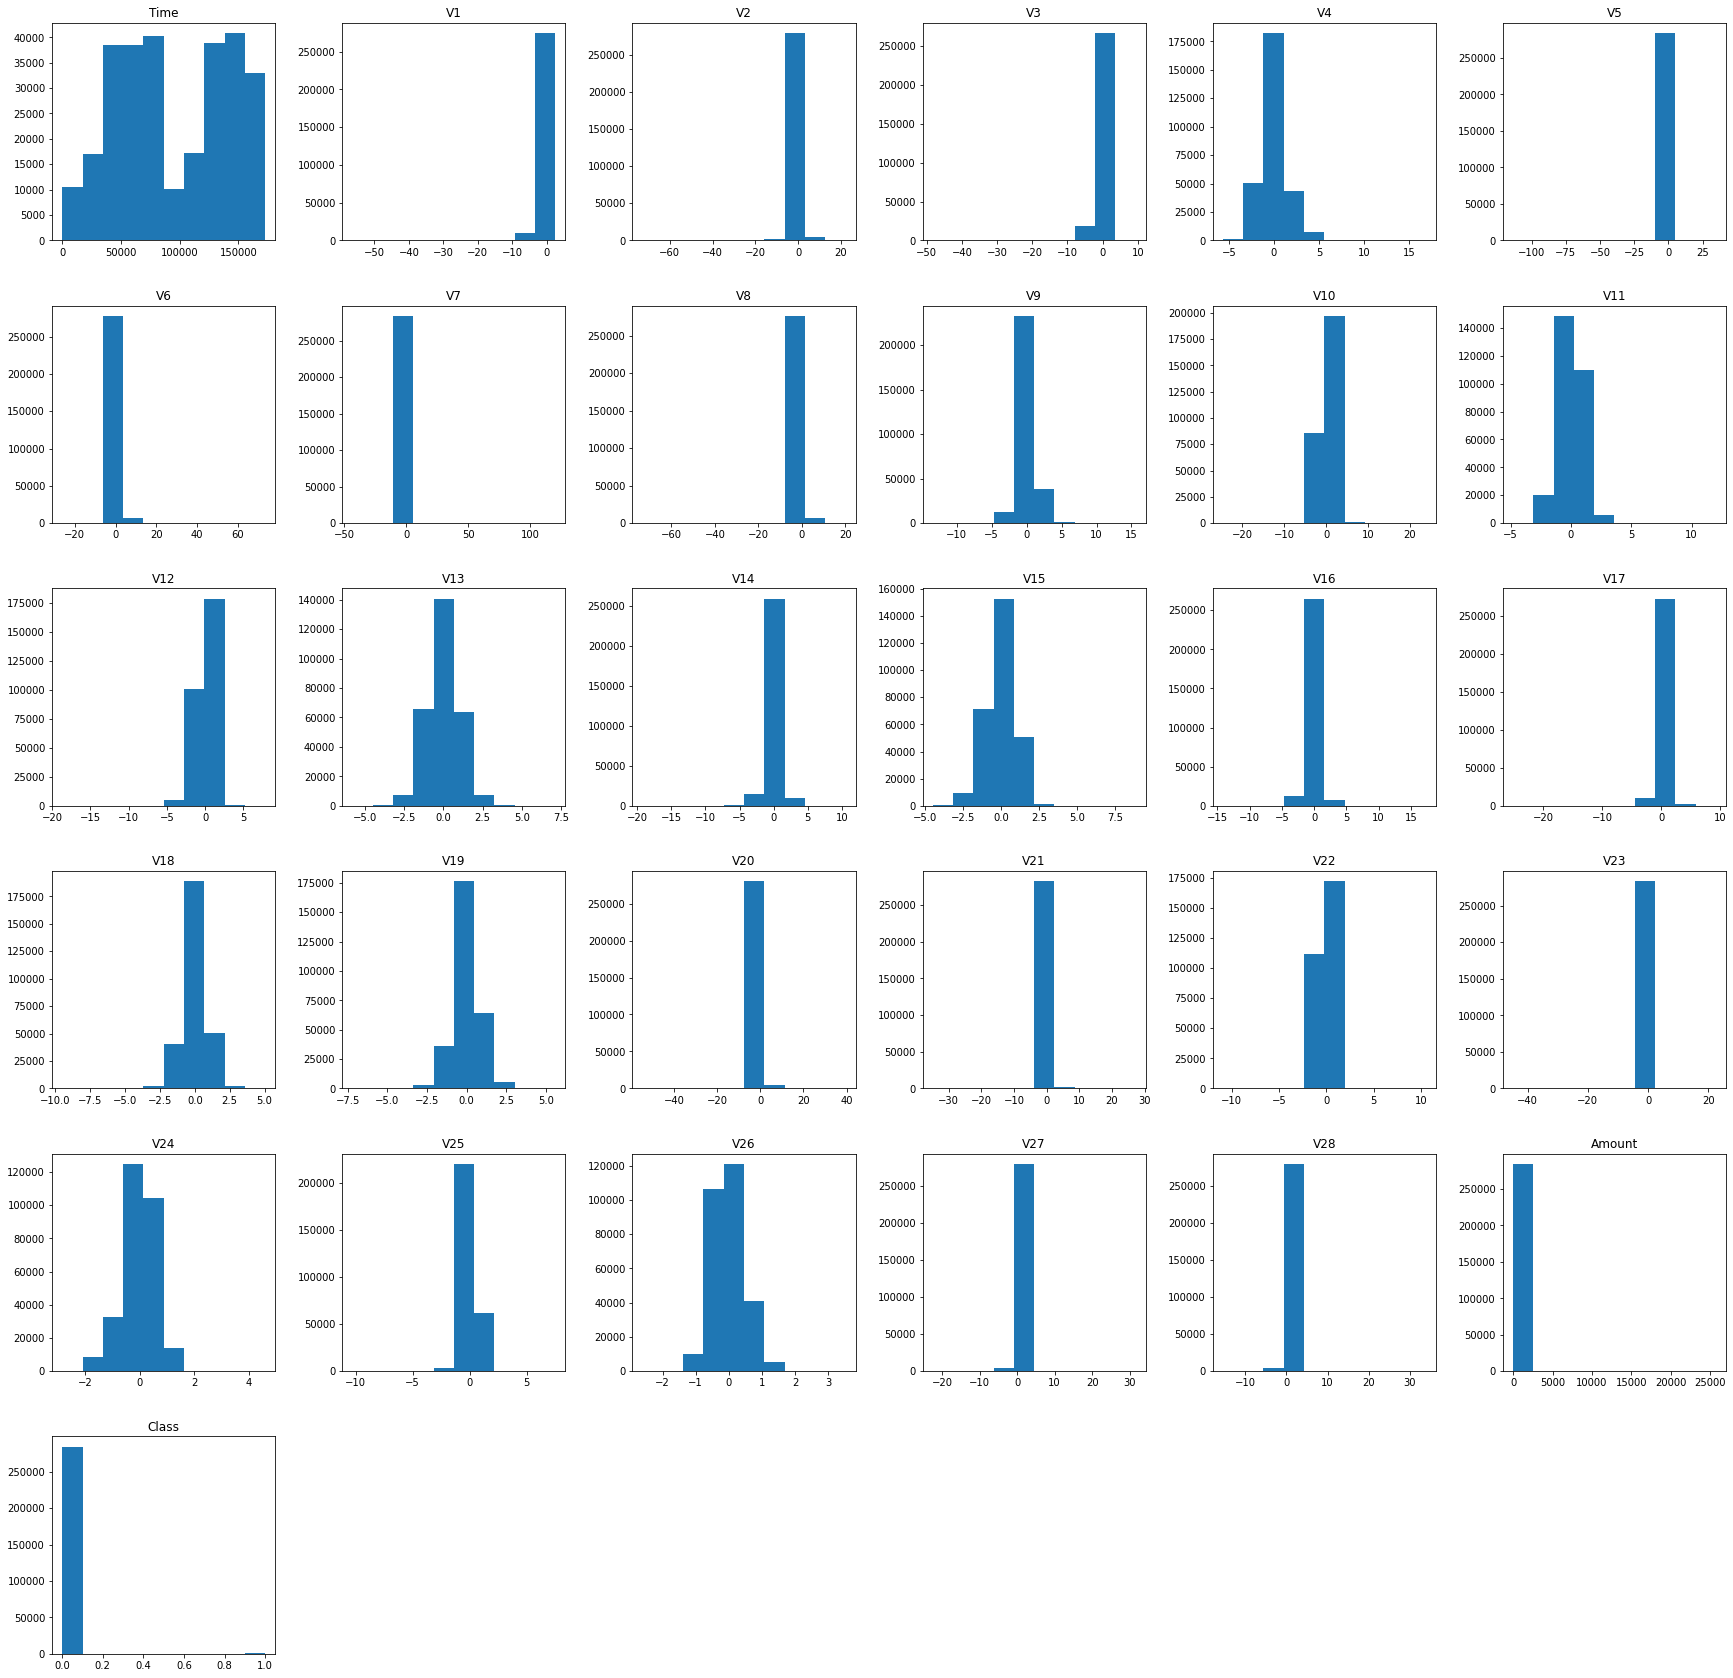

In [10]:
# examining data distribution
df.hist(figsize=(30,30), grid=False);

## Data scaling & resampling

To prevent bias from differences in magnitudes between our features, I decided to scale the data. 

Furthermore, since the dataset is highly imbalanced, I decided to create a sample of the data containing an equal distribution of legitimate and fraudulent records to train my model. This will prevent overfitting, and the identification of incorrect correlations between the unlabeled features (V...) and class.

In [11]:
# scaling the `Time` and `Amount` columns
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
# sampling the dataset

# shuffling records in the dataframe
df1 = df.sample(frac=1)

# create a sample with 500 records
fraud_df = df.loc[df['Class'] == 1][:400]
legit_df = df.loc[df['Class'] == 0][:400]
df2 = pd.concat([fraud_df, legit_df])

# shuffling records in the dataframe
df2 = df2.sample(frac=1, random_state=24)
df2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
231,1.315601,0.413148,-0.018953,0.487834,0.132331,-0.574307,0.146563,-0.215923,-0.080276,-0.314457,...,-0.891188,0.011352,-0.477579,0.365667,0.143254,-0.016757,0.024640,0,-0.279746,-0.993174
184379,-1.141559,1.927650,-3.905356,-0.073943,-0.044858,-1.756999,-1.217416,0.364563,-2.770148,-3.216188,...,-0.531496,-0.328741,0.393100,0.568435,0.786605,-0.146102,0.076211,1,0.041920,0.487870
42549,-5.314173,4.145944,-8.532522,8.344392,-5.718008,-3.043536,-10.989185,3.404129,-6.167234,-11.435624,...,0.862996,-0.614453,0.523648,-0.712593,0.324638,2.245091,0.497321,1,0.925452,-0.511578
214662,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,-1.065016,-5.416037,...,0.899876,-0.285103,-1.929717,0.319869,0.170636,0.851798,0.372098,1,1.376930,0.647035
154633,-1.020632,1.496959,-4.490937,1.836727,0.627318,-2.735569,-1.546274,0.459822,-0.682741,-4.363102,...,0.860618,-0.304666,-0.155500,0.412166,-0.220080,0.392338,-0.020089,1,0.000559,0.207075


## Correlation analyses

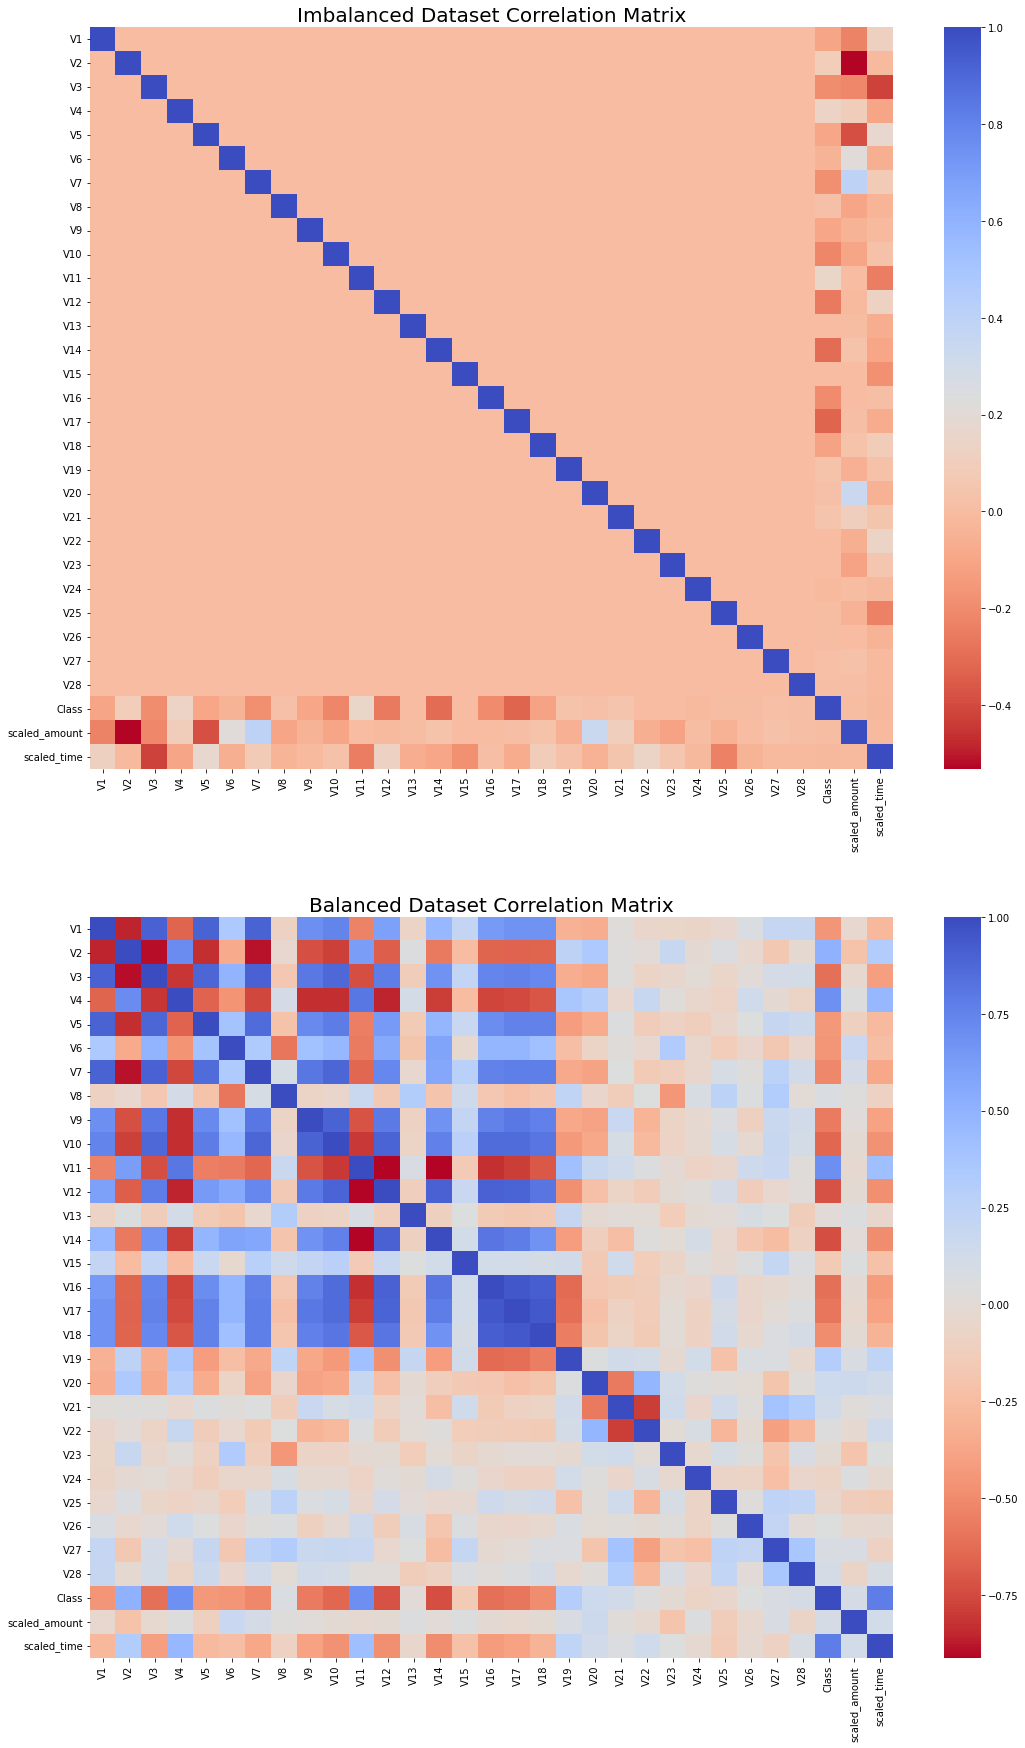

In [13]:
# correlation analyses
corr_0 = df.corr()
corr_1 = df2.corr()

# correlation maps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,30))
sns.heatmap(corr_0, cmap='coolwarm_r', ax=ax1)
sns.heatmap(corr_1, cmap='coolwarm_r', ax=ax2)

ax1.set_title("Imbalanced Dataset Correlation Matrix", fontsize=20)
ax2.set_title("Balanced Dataset Correlation Matrix", fontsize=20)
plt.show()

**Note:** In the imbalanced dataset, no relevant correlations were found. On ther other hand, correlation analyses on the balanced dataset reveals pertinent relationships between fraudulent interactions and V2, V4, V10, V11, V12, V14, V17 & V19.

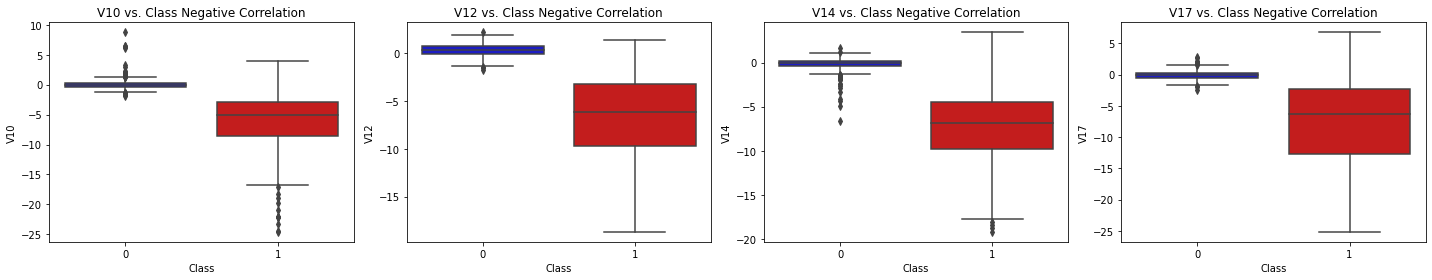

In [14]:
# visualizing negatively correlated variables
fig, axs = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V10", data=df2, ax=axs[0], palette=colors)
axs[0].set_title('V10 vs. Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=df2, ax=axs[1], palette=colors)
axs[1].set_title('V12 vs. Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df2, ax=axs[2], palette=colors)
axs[2].set_title('V14 vs. Class Negative Correlation')

sns.boxplot(x="Class", y="V17", data=df2, ax=axs[3], palette=colors)
axs[3].set_title('V17 vs. Class Negative Correlation')

plt.tight_layout()
plt.show()

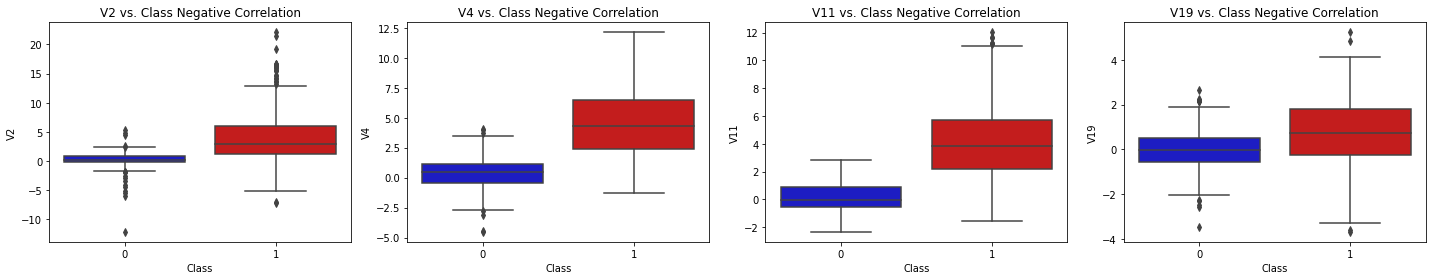

In [15]:
# visualizing positively correlated variables
fig, axs = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V2", data=df2, ax=axs[0], palette=colors)
axs[0].set_title('V2 vs. Class Negative Correlation')

sns.boxplot(x="Class", y="V4", data=df2, ax=axs[1], palette=colors)
axs[1].set_title('V4 vs. Class Negative Correlation')

sns.boxplot(x="Class", y="V11", data=df2, ax=axs[2], palette=colors)
axs[2].set_title('V11 vs. Class Negative Correlation')

sns.boxplot(x="Class", y="V19", data=df2, ax=axs[3], palette=colors)
axs[3].set_title('V19 vs. Class Negative Correlation')

plt.tight_layout()
plt.show()

## Dimensionality reduction & clustering analyses

In [16]:
# defining the features and target variables
X = df2.drop('Class', axis=1)
y = df2['Class']

In [17]:
# dimensionality reductions using t-SNE, PCA and TruncatedSVD
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
X_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)

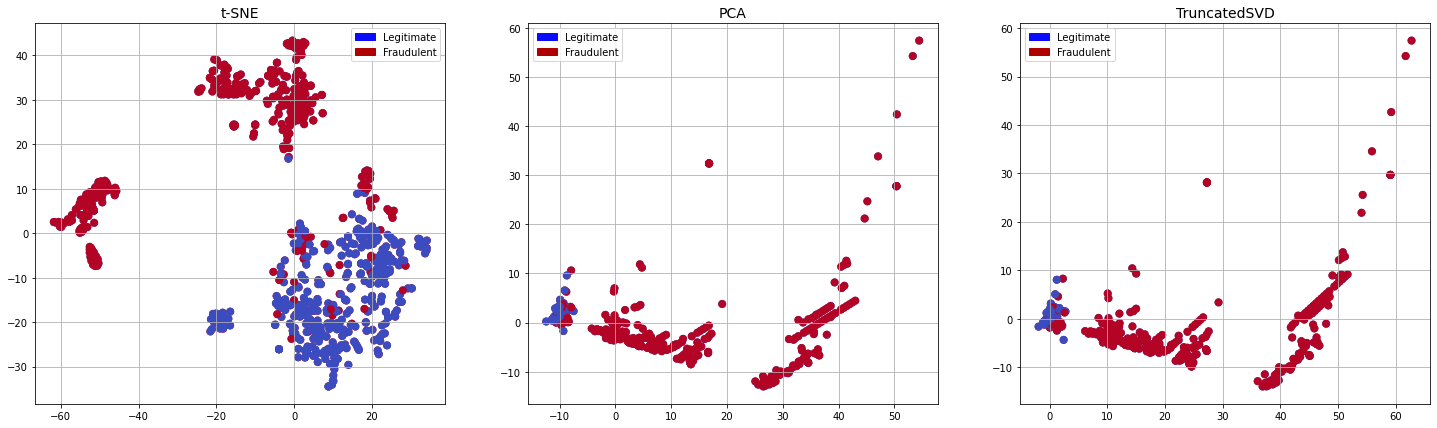

In [18]:
# visualizing the clusters
fig, axs = plt.subplots (1, 3, figsize=(25, 7))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Legitimate')
red_patch = mpatches.Patch(color='#AF0000', label='Fraudulent')

# t-SNE
axs[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Legitimate', linewidths=2)
axs[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraudulent', linewidths=2)
axs[0].set_title('t-SNE', fontsize=14)
axs[0].legend(handles=[blue_patch, red_patch])
axs[0].grid(True)

# PCA
axs[1].scatter(X_pca[:,0], X_pca[:,1], c=(y == 0), cmap='coolwarm', label='Legitimate', linewidths=2)
axs[1].scatter(X_pca[:,0], X_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraudulent', linewidths=2)
axs[1].set_title('PCA', fontsize=14)
axs[1].legend(handles=[blue_patch, red_patch])
axs[1].grid(True)

# SVD
axs[2].scatter(X_svd[:,0], X_svd[:,1], c=(y == 0), cmap='coolwarm', label='Legitimate', linewidths=2)
axs[2].scatter(X_svd[:,0], X_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraudulent', linewidths=2)
axs[2].set_title('TruncatedSVD', fontsize=14)
axs[2].legend(handles=[blue_patch, red_patch])
axs[2].grid(True)


## Classification analyses

I will be testing four classifiers, namely Logistic Regression, KNearest Neighbours, Support Vector Classifier and Decision Tree Classifier

In [19]:
# defining the features and target variables
X = df2.drop('Class', axis=1)
y = df2['Class']

# splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# classifier implementation
classifiers = {"Logisitic Regression": LogisticRegression(),
               "KNearest Neigbours": KNeighborsClassifier(),
               "Support Vector Classifier": SVC(),
               "Decision Tree Classifier": DecisionTreeClassifier()}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, 
          "has a cross validation score of", 
          round(training_score.mean(), 2))

Classifiers:  LogisticRegression has a cross validation score of 0.98
Classifiers:  KNeighborsClassifier has a cross validation score of 0.95
Classifiers:  SVC has a cross validation score of 0.94
Classifiers:  DecisionTreeClassifier has a cross validation score of 1.0


**Note:** All classifiers performed with high accuracy, but the Decision Tree Classifier performed the best with a cross validation score of 100%.

In [21]:
# using GridSearchCV to find best parameters for the classifiers
# Logistic Regression 
log_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log = GridSearchCV(LogisticRegression(), log_params)
grid_log.fit(X_train, y_train)
log = grid_log.best_estimator_

# KNN
knn_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_train, y_train)
knn = grid_knn.best_estimator_

# SVC
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# Decision Tree
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree = grid_tree.best_estimator_

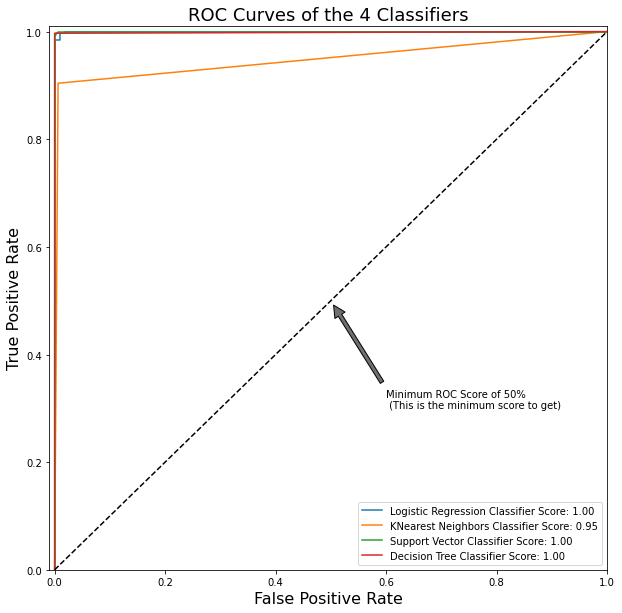

In [22]:
# visualizing ROC Curves
# predicted values
log_pred = cross_val_predict(log, X_train, y_train, cv=5,
                             method="decision_function")
knn_pred = cross_val_predict(knn, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")
tree_pred = cross_val_predict(tree, X_train, y_train, cv=5)

# roc
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_pred)
knn_fpr, knn_tpr, knn_threshold = roc_curve(y_train, knn_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(10,10))
    plt.title('ROC Curves of the 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.2f}'.format(roc_auc_score(y_train, log_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNearest Neighbors Classifier Score: {:.2f}'.format(roc_auc_score(y_train, knn_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.2f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.2f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knn_fpr, knn_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [23]:
# predicting fraudulent activity
y_pred_log = log.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree.predict(X_test)

# building confusion matrices
log = confusion_matrix(y_test, y_pred_log)
knn = confusion_matrix(y_test, y_pred_knn)
svc = confusion_matrix(y_test, y_pred_svc)
tree = confusion_matrix(y_test, y_pred_tree)

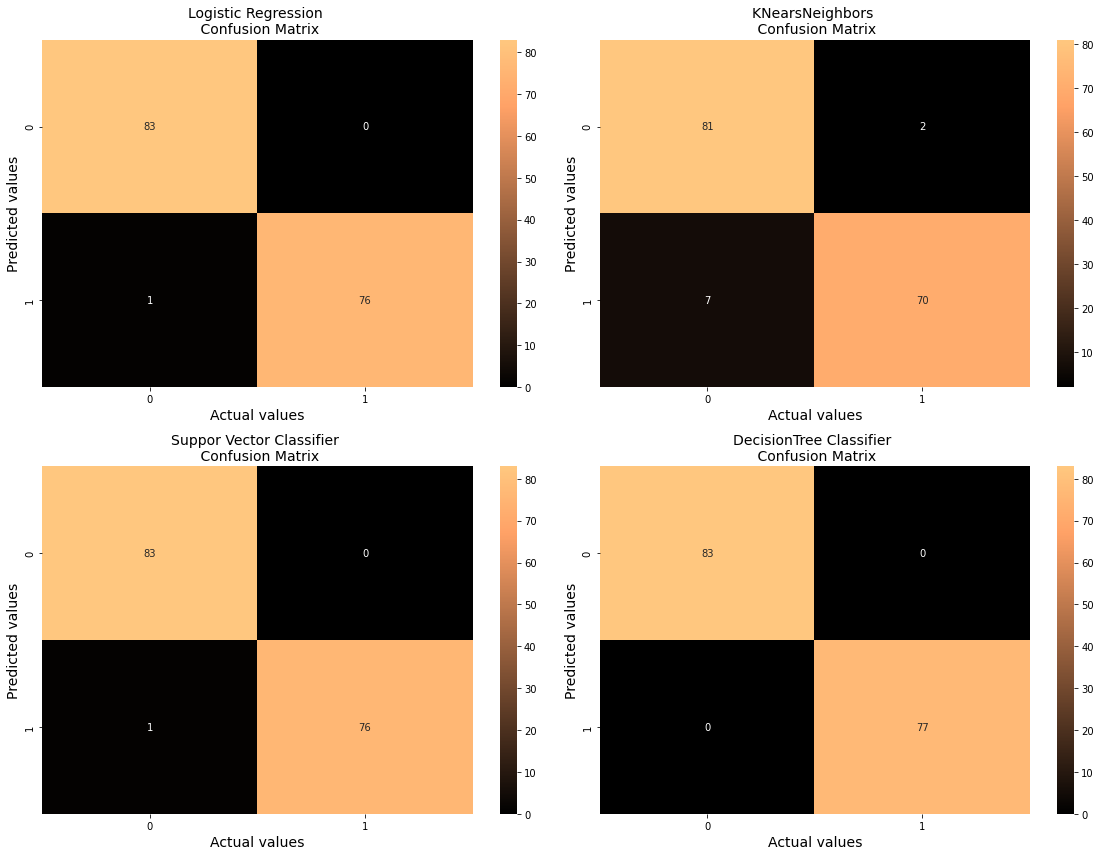

In [24]:
# visualizing confusion matrices
fig, ax = plt.subplots(2, 2,figsize=(16,12))

sns.heatmap(log, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
sns.heatmap(knn, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
sns.heatmap(svc, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
sns.heatmap(tree, ax=ax[1][1], annot=True, cmap=plt.cm.copper)

ax[0][0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0][0].set_xlabel("Actual values", fontsize=14)
ax[0][0].set_ylabel("Predicted values", fontsize=14)

ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xlabel("Actual values", fontsize=14)
ax[0][1].set_ylabel("Predicted values", fontsize=14)

ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xlabel("Actual values", fontsize=14)
ax[1][0].set_ylabel("Predicted values", fontsize=14)

ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xlabel("Actual values", fontsize=14)
ax[1][1].set_ylabel("Predicted values", fontsize=14)

plt.tight_layout()
plt.show()

In [25]:
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knn))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        83
           1       1.00      0.99      0.99        77

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        83
           1       0.97      0.91      0.94        77

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        83
           1       1.00      0.99      0.99        77

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted

## SMOTE for imbalanced classification

Since the decision tree classifier outperformed the other classifiers, it was applied within the SMOTE pipeline.

In [26]:
# defining the features and target variables
X = df.drop('Class', axis=1)
y = df['Class']

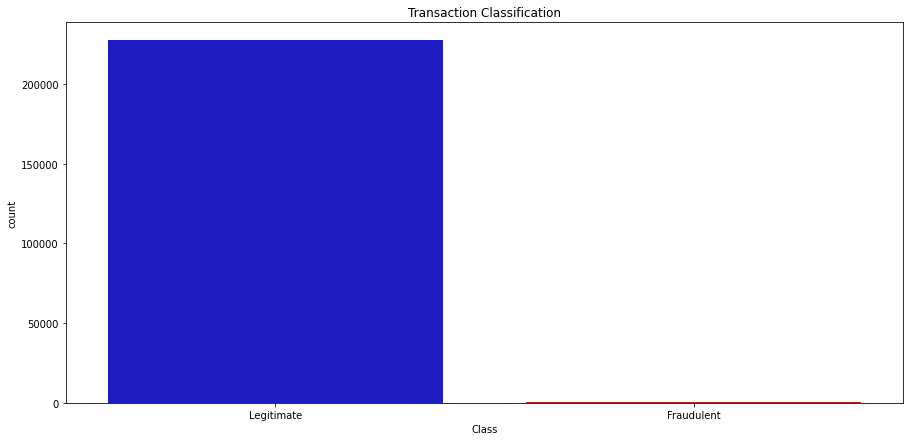

In [27]:
# splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# visualizing dataset imbalance
x, labels = [0, 1], ['Legitimate', 'Fraudulent']

plt.figure(figsize=(15,7))
sns.countplot(x=y_train, palette=colors)
plt.xticks(x, labels)
plt.title('Transaction Classification')
plt.show()

In [28]:
# initalizing and fitting the classifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.83      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962



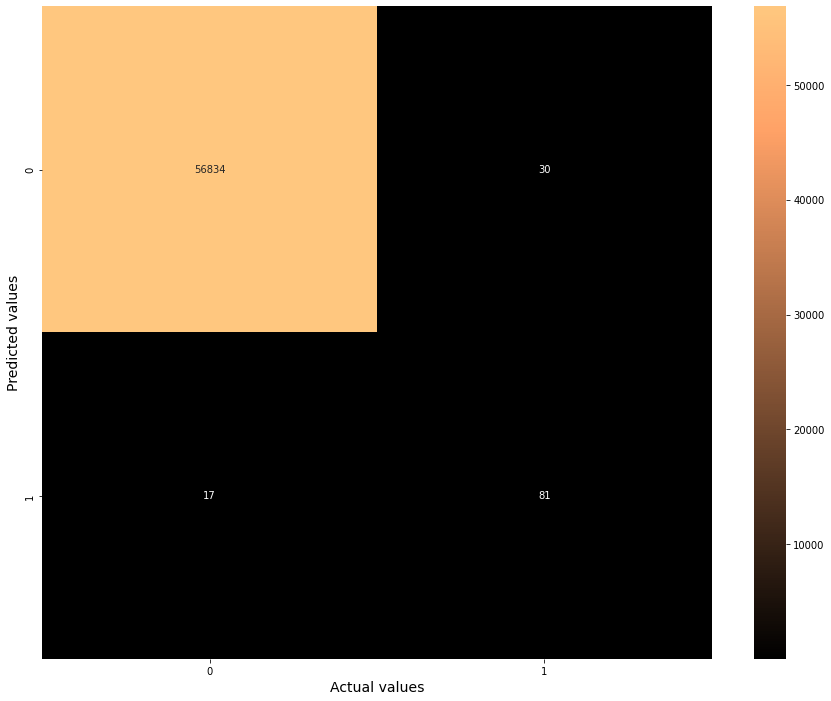

In [29]:
# evaluating the classifier on the imbalanced dataset
y_pred = tree.predict(X_test)
tree_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

fig = plt.figure(figsize=(15,12))
sns.heatmap(tree_cm, annot=True, fmt='0.0f', cmap=plt.cm.copper)
plt.xlabel("Actual values", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.show()

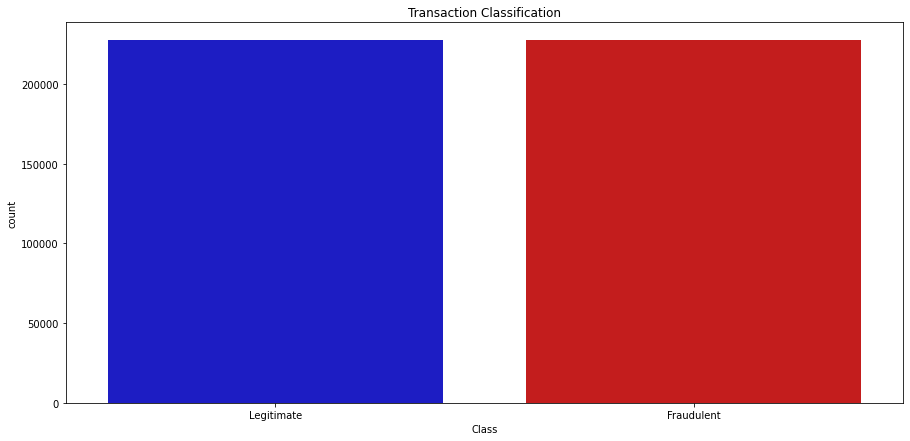

In [30]:
# resampling with SMOTE (test to visualize changes to our dataset)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# visualizing balanced training dataset 
x, labels = [0, 1], ['Legitimate', 'Fraudulent']

plt.figure(figsize=(15,7))
sns.countplot(x=y_res, palette=colors)
plt.xticks(x, labels)
plt.title('Transaction Classification')
plt.show()

**Note:** For this step, I chose to oversample the fraudulent records (minority) and randomly sample the legitimate records for higher accuracy and reduce overfitting.

In [31]:
# defining the features and target variables
X = df.drop('Class', axis=1)
y = df['Class']

# splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# evaluate pipeline using the test, cross-validation and prediction scores
pipeline.fit(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

y_pred = pipeline.predict(X_test)

print(f'Cross-validation score: {np.mean(cv_scores)}\nTest score: {test_score}')
print('\nClassification report \n', classification_report(y_test, y_pred))

Cross-validation score: 0.9059742066781974
Test score: 0.9919771075453812

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.85      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.92      0.63     56962
weighted avg       1.00      0.99      0.99     56962



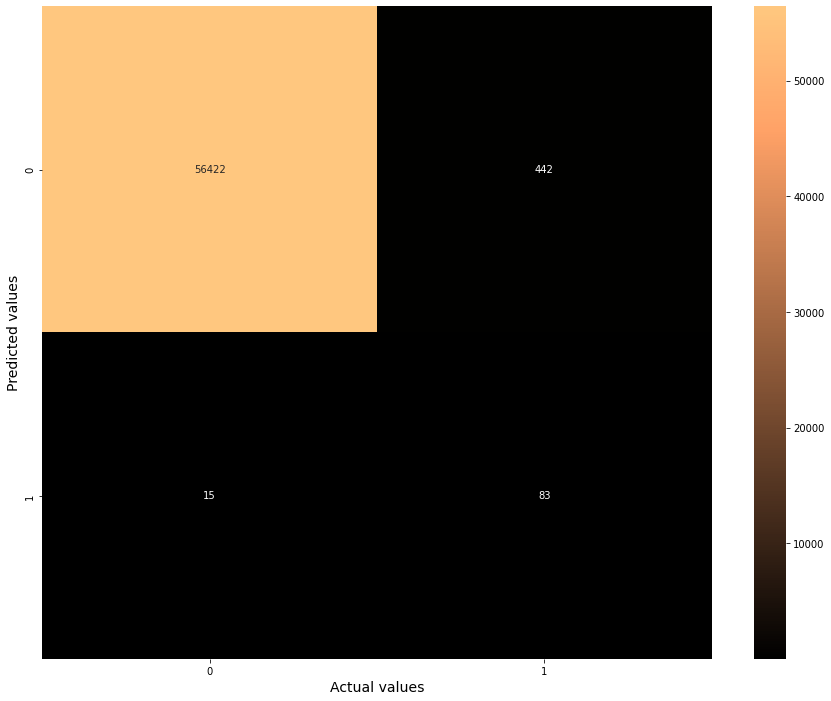

In [32]:
# visualizing the confusion matrix
tree_cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(15,12))
sns.heatmap(tree_cm, annot=True, fmt='0.0f', cmap=plt.cm.copper)
plt.xlabel("Actual values", fontsize=14)
plt.ylabel("Predicted values", fontsize=14)
plt.show()

## Summary

Although resampling improved the performance of the classification models, with an accuracy over 94%, SMOTE did not improve models' performances. Indeed, the precision and f1-scores for modeling on the balanced dataset were 60% lower than that of the imbalanced dataset.